## Imports y data load

In [29]:
# Standard library
import os
from datetime import datetime
from imblearn.pipeline import Pipeline
from pathlib import Path
import sys

# Data & Numerical
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import optuna
from scipy.stats import uniform, randint

# Scikit-learn
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, 
    ConfusionMatrixDisplay, f1_score, make_scorer, 
    precision_score, recall_score, roc_auc_score)
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

# Imbalanced-learn
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Gradient Boosting
import lightgbm as lgb
import xgboost as xgb


In [30]:
# Add parent directory to path
parent_dir = Path().resolve().parent
sys.path.insert(0, str(parent_dir))

# Custom imports
from scripts.results_analyzer_multiclase import ResultsAnalyzerMulticlase

In [31]:
df_int_multiclase = pd.read_csv('../data/base_procesada_multiclase.csv')

In [32]:
X = df_int_multiclase.drop(columns=['target_multiclase'])
y = df_int_multiclase['target_multiclase']

In [33]:
#Dividir en train y test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y)

In [34]:
analyzer = ResultsAnalyzerMulticlase()

# Modelo multiclase

## KNN

In [ ]:
# Se escalan los datos y se hace una búsqueda de hiperparámetros con grds search, buscando el k número de vecinos óptimo.
# Evalúa la clasificación con f1_weighted. weighted se usa a lo largo de toda la medición porque evita que las clases minoritarias sean ignoradas en la métrica global.
# Calcula el F1 por clase y hace promedio ponderado por la cantidad de ejemplos de cada clase. 
# Así las clases grandes pesan más, pero las pequeñas también cuentan.

pipeline = ImbPipeline([
    ('scaler', StandardScaler()), 
    ('classifier', KNeighborsClassifier(
        n_jobs=-1
    ))
])


param_grid = {
    'classifier__n_neighbors': range(3, 21), 
    'classifier__weights': ['uniform', 'distance'],  
    'classifier__metric': ['euclidean', 'manhattan', 'minkowski'],
    'classifier__p': [1, 2]
}

scoring = {
    'balanced_acc': 'balanced_accuracy',
    'f1_macro': 'f1_macro',
    'f1_weighted': 'f1_weighted'
}


grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring=scoring,
    refit='balanced_acc',
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

grid_search.fit(X_train, y_train)


# Usar mejor modelo
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)



Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[CV] END classifier__metric=euclidean, classifier__n_neighbors=3, classifier__p=1, classifier__weights=uniform; total time=   1.3s
[CV] END classifier__metric=euclidean, classifier__n_neighbors=3, classifier__p=1, classifier__weights=uniform; total time=   1.2s
[CV] END classifier__metric=euclidean, classifier__n_neighbors=3, classifier__p=1, classifier__weights=distance; total time=   1.2s
[CV] END classifier__metric=euclidean, classifier__n_neighbors=3, classifier__p=1, classifier__weights=uniform; total time=   1.6s
[CV] END classifier__metric=euclidean, classifier__n_neighbors=3, classifier__p=1, classifier__weights=uniform; total time=   1.5s
[CV] END classifier__metric=euclidean, classifier__n_neighbors=3, classifier__p=2, classifier__weights=uniform; total time=   1.5s
[CV] END classifier__metric=euclidean, classifier__n_neighbors=3, classifier__p=1, classifier__weights=distance; total time=   1.3s
[CV] END classifi


RESULTADOS EN TEST SET - KNN MULTICLASE
Accuracy:  0.7709
Precision weighted: 0.7643
Recall weighted:    0.7709
F1-Score weighted:  0.7522
ROC-AUC multiclase ponderada:   0.8754

------------------------------------------------------------
REPORTE DE CLASIFICACIÓN:
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.83      0.94      0.88      7137
           1       0.61      0.59      0.60      2817
           2       0.76      0.31      0.44      1548

    accuracy                           0.77     11502
   macro avg       0.73      0.61      0.64     11502
weighted avg       0.76      0.77      0.75     11502



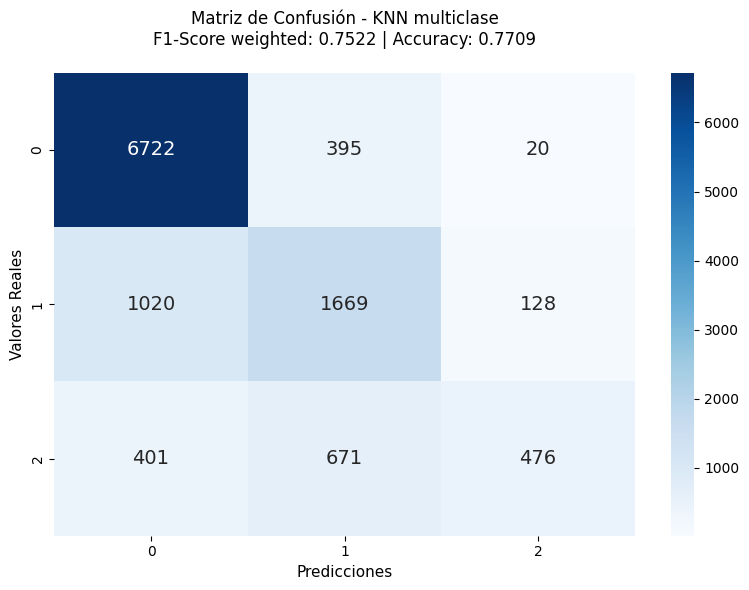

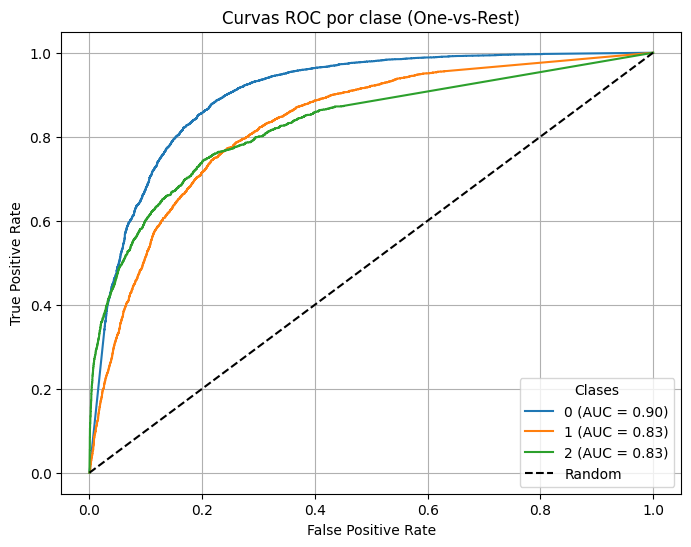

In [ ]:
results_df = analyzer.evaluar_y_guardar_modelo(grid_search, X_test, y_test, y_pred, y_pred_proba,
                          nombre_modelo="KNN multiclase")

In [ ]:
results_df.to_csv('../results/resultados_modelos_multiclase.csv', index=False)

,Modelo,Hiperparametros,Accuracy,F1_Score weighted,Precision weighted,Recall weighted,ROC-AUC multiclase ponderada,CV_F1_weighted_Mean,CV_F1_weighted_Std,Fecha
0,KNN multiclase,"{'classifier__metric': 'manhattan', 'classifie...",0.7709,0.7522,0.7643,0.7709,0.8754,0.7457,0.0025,2025-10-17 14:52:22


##  Boosting y Bagging

### Random Forest

In [ ]:
# Pipeline para Random Forest
pipeline_rf = Pipeline([
    ('classifier', RandomForestClassifier(random_state=42))
])

# Parámetros para GridSearch
param_grid_rf = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5],
    'classifier__class_weight': ['balanced', None]
}

grid_search_rf = GridSearchCV(
    pipeline_rf,
    param_grid_rf,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1
)

grid_search_rf.fit(X_train, y_train)


# Usar mejor modelo
best_model = grid_search_rf.best_estimator_
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)

Fitting 5 folds for each of 36 candidates, totalling 180 fits



RESULTADOS EN TEST SET - RANDOM FOREST MULTICLASE
Accuracy:  0.7843
Precision weighted: 0.7837
Recall weighted:    0.7843
F1-Score weighted:  0.7803
ROC-AUC multiclase ponderada:   0.9004

------------------------------------------------------------
REPORTE DE CLASIFICACIÓN:
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.87      0.90      0.89      7137
           1       0.60      0.66      0.63      2817
           2       0.71      0.47      0.57      1548

    accuracy                           0.78     11502
   macro avg       0.73      0.68      0.69     11502
weighted avg       0.78      0.78      0.78     11502



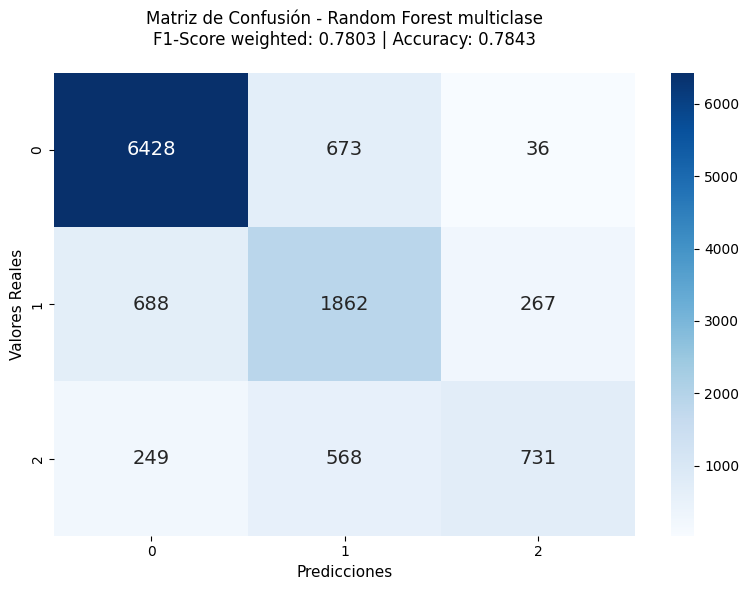

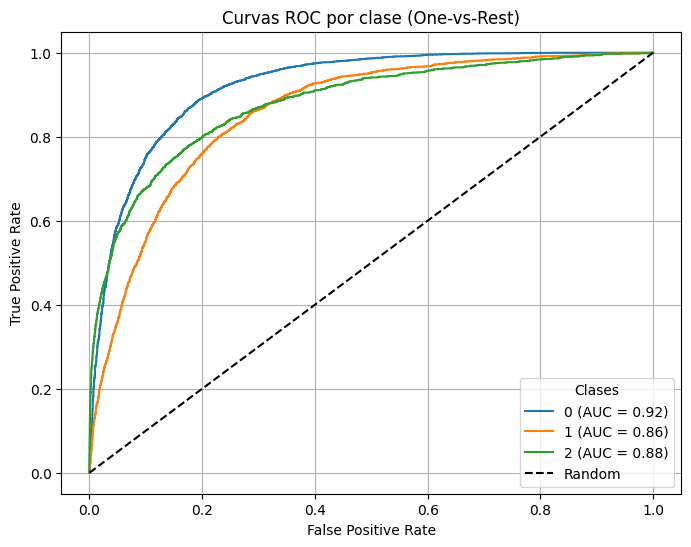

In [ ]:
results = analyzer.evaluar_y_guardar_modelo(grid_search_rf, X_test, y_test, y_pred, y_pred_proba,
                          nombre_modelo="Random Forest multiclase")

In [ ]:
results_df = pd.concat([results_df, results], ignore_index=True)
results_df.to_csv('../results/resultados_modelos_multiclase.csv', index=False)

Pipeline detectado. Usando: RandomForestClassifier


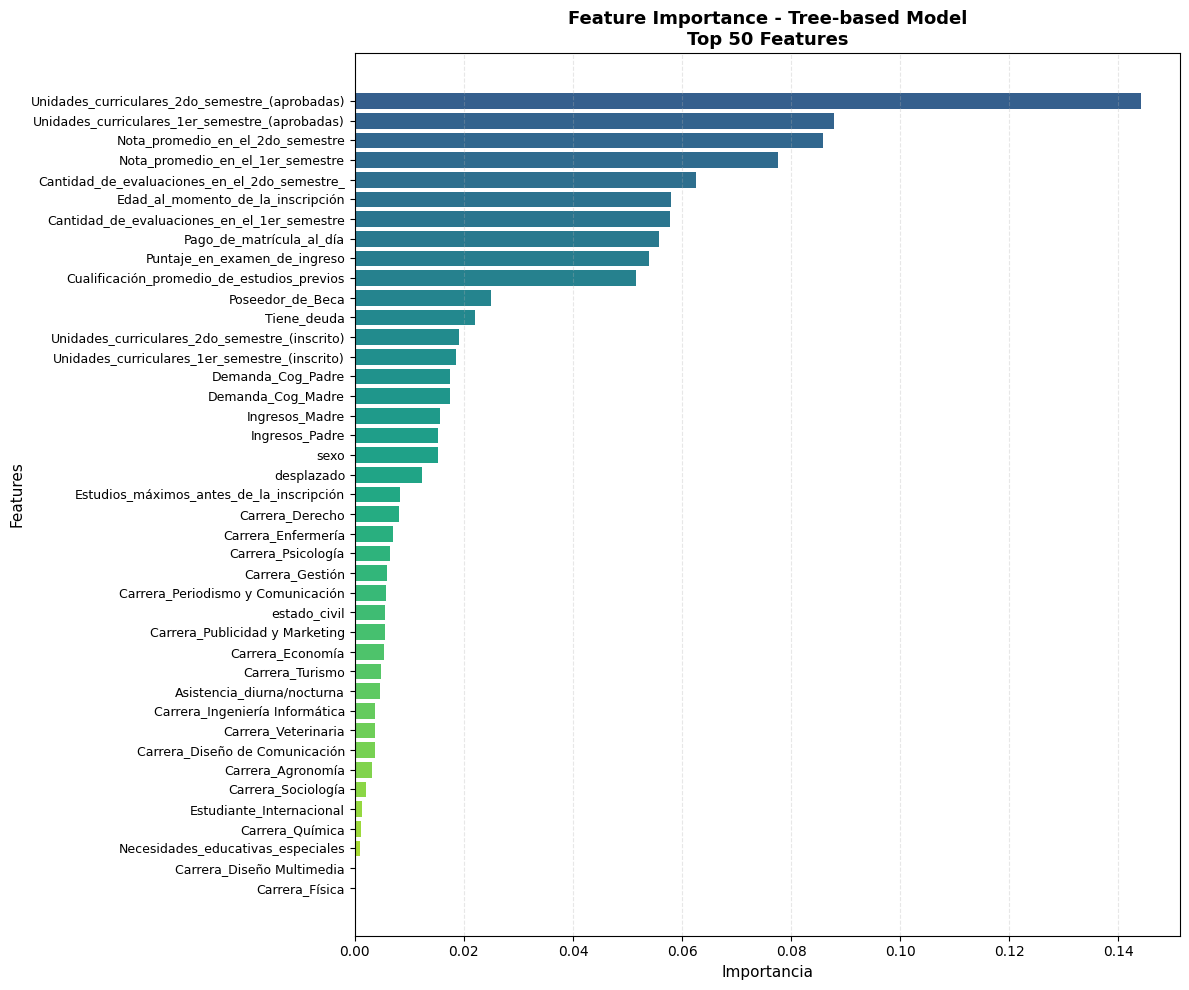


Top 41 Features:
                                       feature  importance
Unidades_curriculares_2do_semestre_(aprobadas)    0.144098
Unidades_curriculares_1er_semestre_(aprobadas)    0.087872
              Nota_promedio_en_el_2do_semestre    0.085920
              Nota_promedio_en_el_1er_semestre    0.077517
  Cantidad_de_evaluaciones_en_el_2do_semestre_    0.062485
             Edad_al_momento_de_la_inscripción    0.058003
   Cantidad_de_evaluaciones_en_el_1er_semestre    0.057706
                      Pago_de_matrícula_al_día    0.055692
                  Puntaje_en_examen_de_ingreso    0.054028
    Cualificación_promedio_de_estudios_previos    0.051497
                              Poseedor_de_Beca    0.025024
                                   Tiene_deuda    0.022021
 Unidades_curriculares_2do_semestre_(inscrito)    0.019094
 Unidades_curriculares_1er_semestre_(inscrito)    0.018533
                             Demanda_Cog_Padre    0.017384
                             Demanda_C

In [ ]:
feature_importance_df = analyzer.plot_feature_importance(
    modelo=best_model,
    X_train=X_train,
    top_n=50,
    figsize=(12, 10))

### Balanced Random Forest Classifier

In [ ]:
from imblearn.ensemble import BalancedRandomForestClassifier


pipeline = Pipeline([
    ('brf', BalancedRandomForestClassifier(random_state=42))
])

param_grid = {
    'brf__n_estimators': [100, 200, 300],
    'brf__max_depth': [10, 20, 30, None],
    'brf__min_samples_split': [2, 5, 10],
    'brf__min_samples_leaf': [1, 2, 4],
    'brf__max_features': ['sqrt', 'log2'],
    'brf__sampling_strategy': ['auto', 'all', 'not majority'], 
    'brf__class_weight': ['balanced', 'balanced_subsample', None] 
}


grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)


grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)

Fitting 5 folds for each of 1944 candidates, totalling 9720 fits
[CV] END brf__class_weight=balanced, brf__max_depth=10, brf__max_features=sqrt, brf__min_samples_leaf=1, brf__min_samples_split=2, brf__n_estimators=100, brf__sampling_strategy=auto; total time=   3.1s
[CV] END brf__class_weight=balanced, brf__max_depth=10, brf__max_features=sqrt, brf__min_samples_leaf=1, brf__min_samples_split=2, brf__n_estimators=100, brf__sampling_strategy=all; total time=   3.1s
[CV] END brf__class_weight=balanced, brf__max_depth=10, brf__max_features=sqrt, brf__min_samples_leaf=1, brf__min_samples_split=2, brf__n_estimators=100, brf__sampling_strategy=auto; total time=   3.1s
[CV] END brf__class_weight=balanced, brf__max_depth=10, brf__max_features=sqrt, brf__min_samples_leaf=1, brf__min_samples_split=2, brf__n_estimators=100, brf__sampling_strategy=auto; total time=   3.1s
[CV] END brf__class_weight=balanced, brf__max_depth=10, brf__max_features=sqrt, brf__min_samples_leaf=1, brf__min_samples_split=

KeyboardInterrupt: 

In [ ]:
results = analyzer.evaluar_y_guardar_modelo(grid_search, X_test, y_test, y_pred, y_pred_proba,
                          nombre_modelo="BalancedRandomForestClassifier")

In [ ]:
results_df = pd.concat([results_df, results], ignore_index=True)
results_df.to_csv('../results/resultados_modelos_multiclase.csv', index=False)

In [ ]:
feature_importance_df = analyzer.plot_feature_importance(
    modelo=best_model,
    X_train=X_train,
    top_n=50,
    figsize=(12, 10))

### LightGBM

In [ ]:
pipeline = Pipeline([
    ('classifier', lgb.LGBMClassifier(
        objective='multiclass',
        class_weight= 'balanced',
        num_class=3,
        random_state=42,
        verbose=-1,
        n_jobs=-1
    ))
])


param_grid = {
    'classifier__n_estimators': randint(100, 800),
    'classifier__max_depth': randint(3, 12),
    'classifier__learning_rate': uniform(0.01, 0.2),
    'classifier__num_leaves': randint(20, 150),
    'classifier__min_child_samples': randint(10, 50),
    'classifier__subsample': uniform(0.6, 0.4),
    'classifier__colsample_bytree': uniform(0.6, 0.4),
    'classifier__reg_alpha': uniform(0, 1),
    'classifier__reg_lambda': uniform(0, 1)
}

grid_search_gbm = RandomizedSearchCV(
    pipeline,
    param_grid,
    n_iter=50,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=2,
    random_state=42,
    return_train_score=True 
)

grid_search_gbm.fit(X_train, y_train)
best_model = grid_search_gbm.best_estimator_

y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END classifier__colsample_bytree=0.7334834444556088, classifier__learning_rate=0.038573363584388155, classifier__max_depth=5, classifier__min_child_samples=31, classifier__n_estimators=408, classifier__num_leaves=21, classifier__reg_alpha=0.7219987722668247, classifier__reg_lambda=0.9385527090157502, classifier__subsample=0.6003115063364057; total time=  38.3s
[CV] END classifier__colsample_bytree=0.7334834444556088, classifier__learning_rate=0.038573363584388155, classifier__max_depth=5, classifier__min_child_samples=31, classifier__n_estimators=408, classifier__num_leaves=21, classifier__reg_alpha=0.7219987722668247, classifier__reg_lambda=0.9385527090157502, classifier__subsample=0.6003115063364057; total time=  38.4s
[CV] END classifier__colsample_bytree=0.7334834444556088, classifier__learning_rate=0.038573363584388155, classifier__max_depth=5, classifier__min_child_samples=31, classifier__n_estimators=408, classif

KeyboardInterrupt: 


RESULTADOS EN TEST SET - BOOSTING LIGHTGBM MULTICLASE
Accuracy:  0.7933
Precision weighted: 0.7852
Recall weighted:    0.7933
F1-Score weighted:  0.7836
ROC-AUC multiclase ponderada:   0.9055

------------------------------------------------------------
REPORTE DE CLASIFICACIÓN:
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.85      0.94      0.89      7137
           1       0.64      0.62      0.63      2817
           2       0.73      0.45      0.56      1548

    accuracy                           0.79     11502
   macro avg       0.74      0.67      0.69     11502
weighted avg       0.79      0.79      0.78     11502



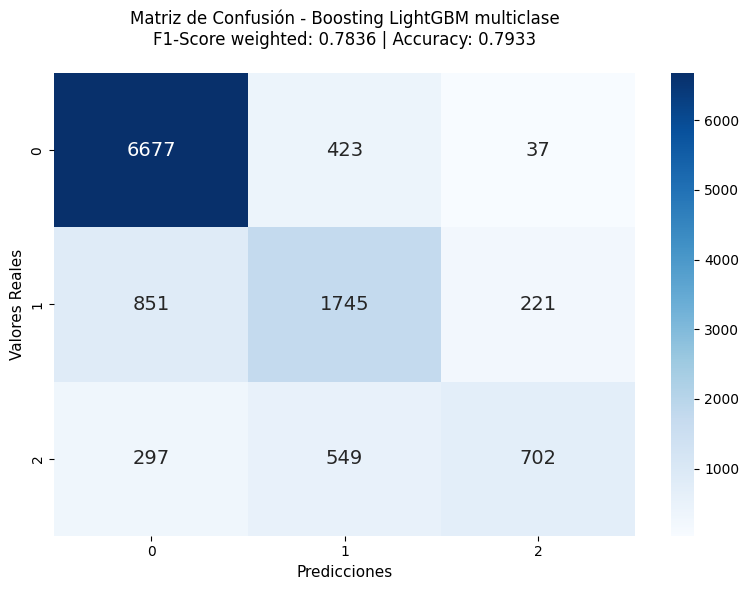

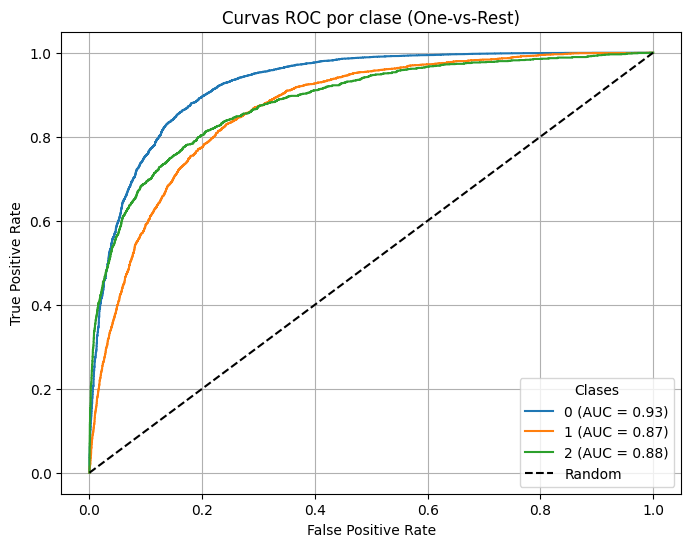

In [ ]:
results = analyzer.evaluar_y_guardar_modelo(grid_search_gbm, X_test, y_test, y_pred, y_pred_proba,
                          nombre_modelo="Boosting LightGBM multiclase")

In [ ]:
results_df = pd.concat([results_df, results], ignore_index=True)
results_df.to_csv('../results/resultados_modelos_multiclase.csv', index=False)

Pipeline detectado. Usando: LGBMClassifier


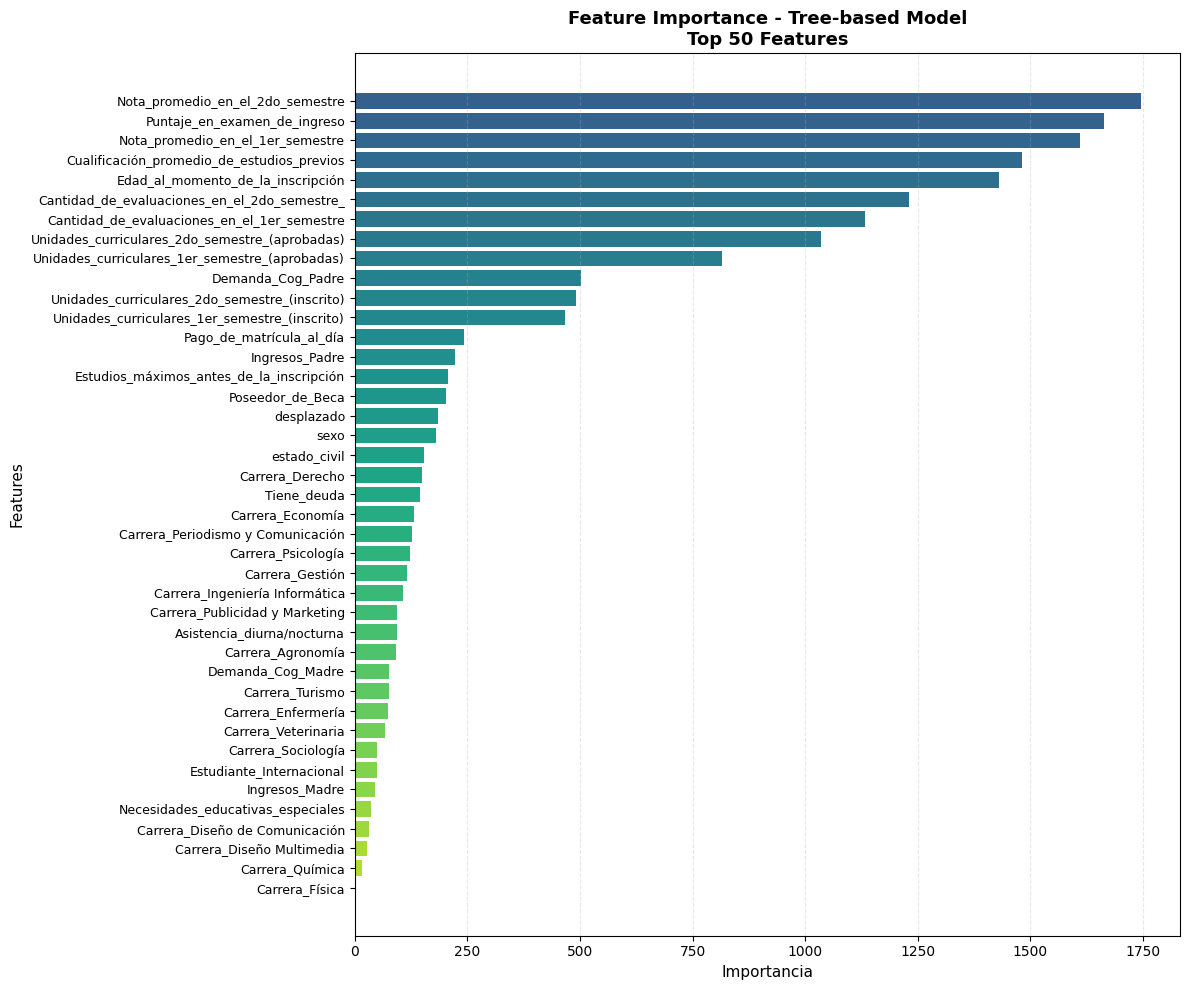


Top 41 Features:
                                       feature  importance
              Nota_promedio_en_el_2do_semestre        1745
                  Puntaje_en_examen_de_ingreso        1663
              Nota_promedio_en_el_1er_semestre        1611
    Cualificación_promedio_de_estudios_previos        1481
             Edad_al_momento_de_la_inscripción        1430
  Cantidad_de_evaluaciones_en_el_2do_semestre_        1230
   Cantidad_de_evaluaciones_en_el_1er_semestre        1132
Unidades_curriculares_2do_semestre_(aprobadas)        1035
Unidades_curriculares_1er_semestre_(aprobadas)         815
                             Demanda_Cog_Padre         503
 Unidades_curriculares_2do_semestre_(inscrito)         491
 Unidades_curriculares_1er_semestre_(inscrito)         466
                      Pago_de_matrícula_al_día         242
                                Ingresos_Padre         223
      Estudios_máximos_antes_de_la_inscripción         208
                              Poseedor

In [ ]:
feature_importance_df = analyzer.plot_feature_importance(
    modelo=best_model,
    X_train=X_train,
    top_n=50,
    figsize=(12, 10))

### XGBoost

In [ ]:
from sklearn.utils.class_weight import compute_sample_weight


sample_weights = compute_sample_weight('balanced', y=y_train)


pipeline = Pipeline([
    ('classifier', xgb.XGBClassifier(
        objective='multi:softprob',
        eval_metric='mlogloss',
        tree_method='hist',
        random_state=42,
        n_jobs=-1,
        early_stopping_rounds=10 
    ))
])


param_grid = {

    'classifier__n_estimators': randint(200, 800),  
    'classifier__max_depth': randint(3, 10),  
    'classifier__learning_rate': uniform(0.01, 0.15),  
\
    'classifier__min_child_weight': randint(3, 15),
    'classifier__gamma': uniform(0, 0.5),
    'classifier__reg_alpha': uniform(0, 2), 
    'classifier__reg_lambda': uniform(1, 3),  

    'classifier__scale_pos_weight': [1, 2, 3] 
}

scoring = {
    'balanced_acc': 'balanced_accuracy',
    'f1_macro': 'f1_macro',
    'f1_weighted': 'f1_weighted'
}


grid_search_xgb = RandomizedSearchCV(
    pipeline,
    param_grid,
    n_iter=100, 
    scoring=scoring,
    refit='balanced_acc', 
    cv=5,
    n_jobs=-1,
    verbose=2,
    random_state=42,
    return_train_score=True
)


grid_search_xgb.fit(
    X_train, y_train,
    classifier__sample_weight=sample_weights,
    classifier__eval_set=[(X_train, y_train)], 
    classifier__verbose=False
)

grid_search_xgb.fit(X_train, y_train)
best_model = grid_search_xgb.best_estimator_

y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END classifier__colsample_bytree=0.7334834444556088, classifier__learning_rate=0.038573363584388155, classifier__max_depth=5, classifier__min_child_weight=6, classifier__n_estimators=408, classifier__reg_alpha=0.9699098521619943, classifier__reg_lambda=0.8324426408004217, classifier__subsample=0.6849356442713105; total time=   3.0s
[CV] END classifier__colsample_bytree=0.7334834444556088, classifier__learning_rate=0.038573363584388155, classifier__max_depth=5, classifier__min_child_weight=6, classifier__n_estimators=408, classifier__reg_alpha=0.9699098521619943, classifier__reg_lambda=0.8324426408004217, classifier__subsample=0.6849356442713105; total time=   3.0s
[CV] END classifier__colsample_bytree=0.7334834444556088, classifier__learning_rate=0.038573363584388155, classifier__max_depth=5, classifier__min_child_weight=6, classifier__n_estimators=408, classifier__reg_alpha=0.9699098521619943, classifier__reg_lambda=0.


RESULTADOS EN TEST SET - BOOSTING XGBOOST MULTICLASE
Accuracy:  0.7970
Precision weighted: 0.7907
Recall weighted:    0.7970
F1-Score weighted:  0.7876
ROC-AUC multiclase ponderada:   0.9070

------------------------------------------------------------
REPORTE DE CLASIFICACIÓN:
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.85      0.94      0.89      7137
           1       0.65      0.63      0.64      2817
           2       0.76      0.46      0.57      1548

    accuracy                           0.80     11502
   macro avg       0.75      0.67      0.70     11502
weighted avg       0.79      0.80      0.79     11502



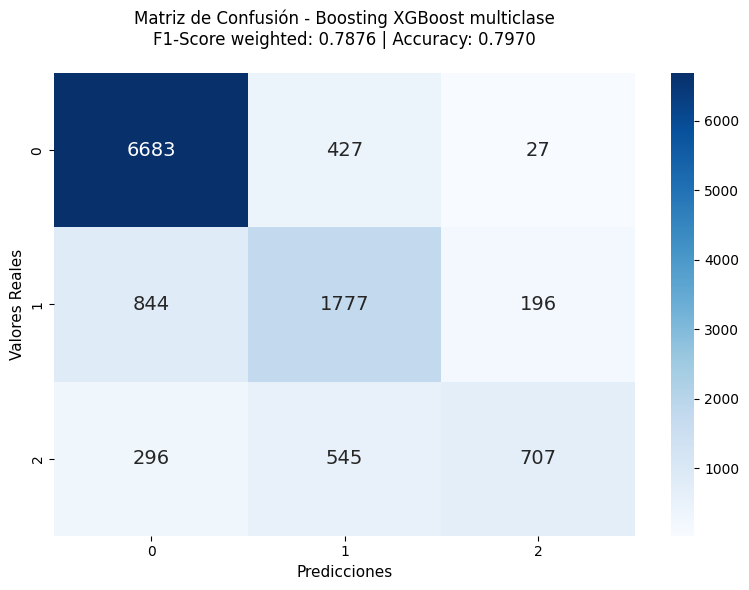

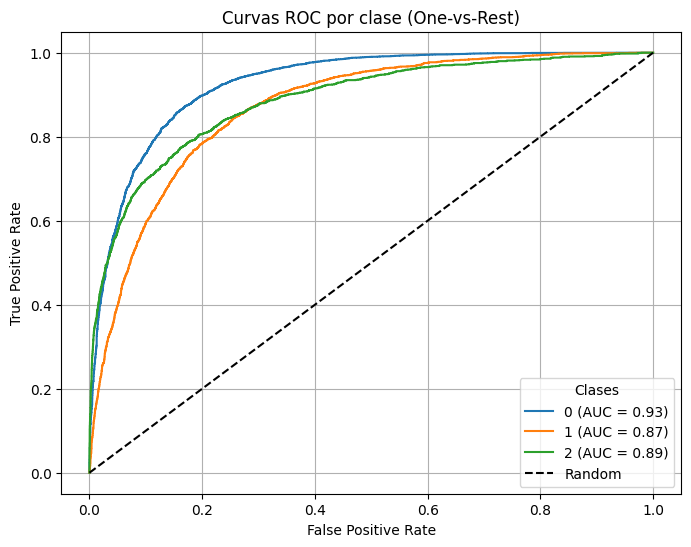

In [ ]:
results = analyzer.evaluar_y_guardar_modelo(grid_search_xgb, X_test, y_test, y_pred, y_pred_proba,
                          nombre_modelo="Boosting XGBoost multiclase")

In [ ]:
results_df = pd.concat([results_df, results], ignore_index=True)
results_df.to_csv('../results/resultados_modelos_multiclase.csv', index=False)

Pipeline detectado. Usando: XGBClassifier


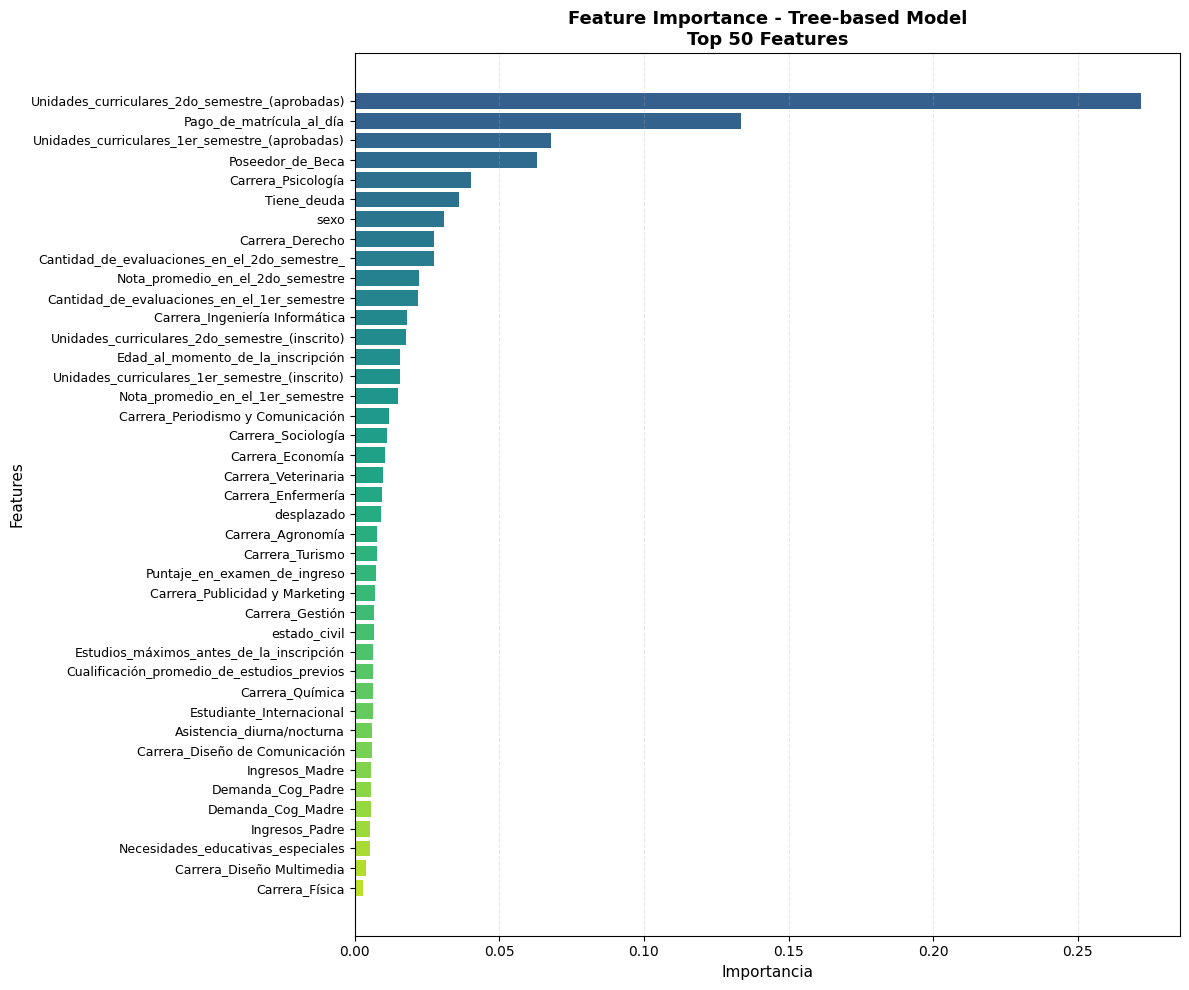


Top 41 Features:
                                       feature  importance
Unidades_curriculares_2do_semestre_(aprobadas)    0.271738
                      Pago_de_matrícula_al_día    0.133547
Unidades_curriculares_1er_semestre_(aprobadas)    0.067867
                              Poseedor_de_Beca    0.062993
                            Carrera_Psicología    0.040206
                                   Tiene_deuda    0.035891
                                          sexo    0.031018
                               Carrera_Derecho    0.027552
  Cantidad_de_evaluaciones_en_el_2do_semestre_    0.027359
              Nota_promedio_en_el_2do_semestre    0.022254
   Cantidad_de_evaluaciones_en_el_1er_semestre    0.021800
                Carrera_Ingeniería Informática    0.018012
 Unidades_curriculares_2do_semestre_(inscrito)    0.017793
             Edad_al_momento_de_la_inscripción    0.015617
 Unidades_curriculares_1er_semestre_(inscrito)    0.015602
              Nota_promedio_en_el_1er_

In [ ]:
feature_importance_df = analyzer.plot_feature_importance(
    modelo=best_model,
    X_train=X_train,
    top_n=50,
    figsize=(12, 10))